# 猫狗大战

这个项目使用 python3.5 + tensorflow 1.0 + gpu环境

In [29]:
# 导入库
import tensorflow as tf
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import time
import sys, traceback

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [75]:
# 全局变量
IMG_SZ = 384
IMG_FT = IMG_SZ * IMG_SZ * 3
LABTXT = ['Cat', 'Dog']


# 可视化
def visualize(imgs, real=None, pred=None):
    size = min(len(imgs), 10)
    fig = plt.figure(figsize=(20, 20))
    for i in range(0, size):
        fig.add_subplot(1, size, i + 1) 
        plt.imshow(imgs[i] + .5)  # display it
        predtxt = 'Algorithm: ' + (pred is not None and LABTXT[int(pred[i])] or '---')
        realtxt = 'Real: ' + (real is not None and LABTXT[int(real[i])] or '---')
        plt.xlabel(predtxt + '  ' + realtxt)
        

def step_info(step, total_step, scores):
    sys.stdout.write('\r--== Step: ' + str(batch) + '/' + str(total_step) +
                     ' (' + str(round(batch/total_steps*100, 1)) + '%)' +
                     ' Score: ' + ', '.join("{!s} {!s}".format(key,val) for (key,val) in scores.items()) +
                     ' ==--')

train datas:  20001
reading from beginning:  train/dog.1336.jpg
reading from beginning:  train/dog.1336.jpg


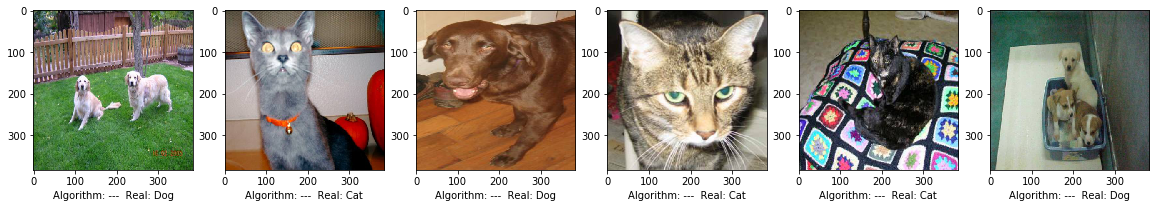

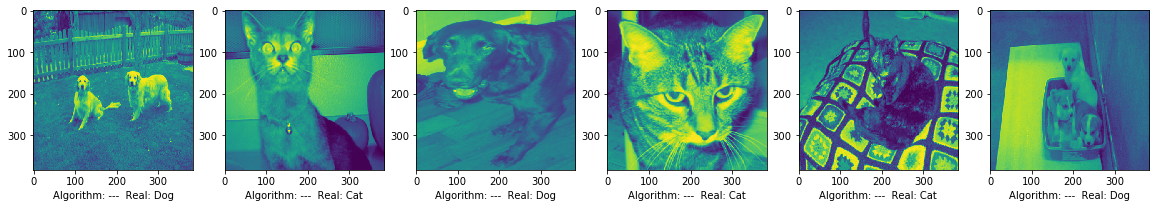

In [50]:
# 数据集加载
import CatDogDataset
CatDogDataset = reload(CatDogDataset)

train, vali, test = CatDogDataset.get_kaggle_reader()
print('train datas: ', train.count)

# 列出数据集里的图 
train_reader = train.get_generator(batch_size=6, image_size=IMG_SZ)
visualize(*next(train_reader))

# 灰度
train_gray_reader = train.get_generator(batch_size=6, image_size=IMG_SZ, gray=True)
visualize(*next(train_gray_reader))

# 使用线性分类 (可跳过执行）

In [77]:
train_reader = train.get_generator(batch_size=128, image_size=IMG_SZ)
vali_reader = vali.get_generator(batch_size=128, image_size=IMG_SZ)
total_steps = int(train.count / 128) + 1

%time vali_dat, vali_lab = next(vali_reader)
vali_dat = vali_dat.reshape(-1, IMG_FT)

from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(penalty='elasticnet', loss='log')

start = time.time()
try:
    for batch in range(0, total_steps):
        dat, lab = next(train_reader)
        dat = dat.reshape(-1, IMG_FT)
        clf.partial_fit(dat, lab, [0,1])
        step_info(batch + 1, total_steps, 
                  {'accuracy': str(round(clf.score(vali_dat, vali_lab)*100, 2)) + '%' })
    print('\nend ', str(time.time() - start), 's')
except Exception as e:
    print('\nerror', e, traceback.format_exc(), str)

reading from beginning:  train/dog.10352.jpg
Wall time: 1.53 s
reading from beginning:  train/dog.1336.jpg
--== Step: 135/156 (86.5%) Score: accuracy 58.59% ==--skip: train/
--== Step: 155/156 (99.4%) Score: accuracy 46.09% ==--reading from beginning:  train/dog.1336.jpg
--== Step: 156/156 (100.0%) Score: accuracy 50.78% ==--
end  428.54400753974915 s


In [79]:
test_reader = test.get_generator(batch_size=500, image_size=IMG_SZ)
from sklearn.metrics import accuracy_score
test_dat, test_lab = next(test_reader)
test_dat = test_dat.reshape(-1, IMG_FT)

y_pred = clf.predict(test_dat)
test_lab = test_lab.reshape(-1)
accuracy_score(test_lab, y_pred)

reading from beginning:  test/6201.jpg


0.54000000000000004

# 使用深度学习

In [73]:
import tensorflow as tf

In [ ]:
import helper
helper = reload(helper)

def my_loss_func(logits, tf_train_labs):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, tf_train_labs))

# Main Model
def my_model(x_input, drop=None):
    depth1, depth2, depth3, depth4 = 32, 64, 64, 256
    with tf.variable_scope("conv1"):
        relu = helper.conv_relu(x_input, kernel_shape=[3, 3, 1, depth1],  pool=True)
        
    with tf.variable_scope("conv2"):
        relu = helper.conv_relu(relu, kernel_shape=[3, 3, depth1, depth2],  pool=True)
        
    with tf.variable_scope("conv3"):
        relu = helper.conv_relu(relu, kernel_shape=[3, 3, depth2, depth3], pool=True)
        
    with tf.variable_scope("fully_connected"):
        shape = relu.get_shape().as_list()
        csize = shape[1] * shape[2] * shape[3]
        reshape = tf.reshape(relu, [-1, csize])    
        relu = helper.relu(reshape, kernel_shape=[csize, depth4], drop=drop)
        
    with tf.variable_scope("out"):
        weights, biases = helper.var([depth4, num_labels * num_seqlen]) #11 * 5 = 55
        logits = tf.matmul(relu, weights) + biases
        return logits, tf.nn.sigmoid(logits)

clf = helper.Learner(my_model, accuracy, 'catdog',
                     steps=1401, batch_size=128, learning_rate=0.005,
                     loss=my_loss_func,
                     optimizer=tf.train.AdamOptimizer
                     )

clf.fit(mnist_train_dat[500:], mnist_train_lab[500:], mnist_test_data[:500], mnist_test_labs[:500])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

# 重新加载数据集
%time train, vali, test = image_process.read_data_sets('./', batch_size=128)

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=[512,512,3]))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit_generator(train, 25000, 100, validation_data=vali, nb_val_samples=32)

Using TensorFlow backend.


Wall time: 357 ms
Epoch 1/100


In [6]:
import tarfile
a = tarfile.open('./images.tar')
print(a)
print(a.getmembers()[10].name)

Images/n02085620-Chihuahua/n02085620_11948.jpg


In [21]:
PET_CLASS = {
    'chihuahua': 0,

    'japanese_spaniel': 1,
    'japanese_chin': 1,


}
CLASSIFIER = re.compile('|'.join([re.escape(c) for c in PET_CLASS]))
print('|'.join([re.escape(c) for c in PET_CLASS]))

japanese_chin|japanese_spaniel|chihuahua


In [64]:
print(CLASSIFIER.search('xxxjapanese_spanielxxxchihuahua'))

<_sre.SRE_Match object; span=(3, 19), match='japanese_spaniel'>


In [55]:
print(PET_CLASS[CLASSIFIER.search('japanese_spaniel').group()])

1
